In [1]:
import numpy as np
import torch

import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

import torch.nn.functional as F
from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt

torch.manual_seed(0)

# Graph Neural Network Model

We will use a two-layer Graph Attention Network.

In [2]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim):
        # fix hparams according to paper
        self.n_heads = 8
        self.dropout = 0.6
        self.hidden_dim = 8
        self.num_classes = 3
        
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, self.hidden_dim, heads=self.n_heads)
        self.conv2 = GATConv(
            self.n_heads * self.hidden_dim, self.num_classes, heads=1
        )
        
    def forward(self, x, edge_index, adj=None):
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.dropout(F.elu(x), p=self.dropout, training=self.training)

        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.dropout(F.elu(x), p=self.dropout, training=self.training)
        return F.softmax(x, dim=1)
       

# PubMed Dataset

We use the `torch_geometric` implementation of this dataset which handles the downloading of source files and preprocessing for us. 

In [3]:
# data_train = EllipticBitcoinDataset(root="./data").data
from torch_geometric.datasets import Planetoid

data_train = Planetoid(root="./data/", name='PubMed').data

Processing...
Done!


In [4]:
# data_train = dataset.data

print(data_train)

print(f"Train set size: {data_train.train_mask.sum().item()} nodes")
print(f"Val set size: {data_train.val_mask.sum().item()} nodes")
print(f"Test set size: {data_train.test_mask.sum().item()} nodes")

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Train set size: 60 nodes
Val set size: 500 nodes
Test set size: 1000 nodes


# Model Training

We save the model locally after training finishes.

In [5]:
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def val(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
    pred = out.argmax(dim=1)
    acc = (pred[data.val_mask] == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
    return acc, loss.item()

In [6]:

# initialise model
num_node_features = data_train['x'].shape[1]
model = GAT(num_node_features)

# Push to GPU if availble
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
data_train = data_train.to(device)

# initialise optimizer for training
LEARNING_RATE = 0.01
WEIGHT_DECAY = 1E-5
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY
)


In [7]:
train_loss_vals = []
val_loss_vals = []
acc_vals = []

n_epochs = 100
for epoch in range(n_epochs):
    # train val iteration
    train_loss = train(model, data_train, optimizer)
    acc, val_loss = val(model, data_train)

    # keep track of metrics 
    train_loss_vals.append(train_loss)
    val_loss_vals.append(val_loss)
    acc_vals.append(acc)

    print(f'Epoch: {epoch:03d}, Loss: {val_loss:.4f}, Accuracy: {acc:.4f}')

Epoch: 000, Loss: -0.3380, Accuracy: 0.4840
Epoch: 001, Loss: -0.3446, Accuracy: 0.5320
Epoch: 002, Loss: -0.3482, Accuracy: 0.4920
Epoch: 003, Loss: -0.3548, Accuracy: 0.4840
Epoch: 004, Loss: -0.3651, Accuracy: 0.5100
Epoch: 005, Loss: -0.3772, Accuracy: 0.5560
Epoch: 006, Loss: -0.3910, Accuracy: 0.5920
Epoch: 007, Loss: -0.4066, Accuracy: 0.6220
Epoch: 008, Loss: -0.4220, Accuracy: 0.6600
Epoch: 009, Loss: -0.4374, Accuracy: 0.7040
Epoch: 010, Loss: -0.4534, Accuracy: 0.7200
Epoch: 011, Loss: -0.4688, Accuracy: 0.7280
Epoch: 012, Loss: -0.4828, Accuracy: 0.7440
Epoch: 013, Loss: -0.4961, Accuracy: 0.7440
Epoch: 014, Loss: -0.5093, Accuracy: 0.7420
Epoch: 015, Loss: -0.5220, Accuracy: 0.7440
Epoch: 016, Loss: -0.5342, Accuracy: 0.7500
Epoch: 017, Loss: -0.5455, Accuracy: 0.7540
Epoch: 018, Loss: -0.5556, Accuracy: 0.7480
Epoch: 019, Loss: -0.5649, Accuracy: 0.7520
Epoch: 020, Loss: -0.5738, Accuracy: 0.7580
Epoch: 021, Loss: -0.5824, Accuracy: 0.7620
Epoch: 022, Loss: -0.5903, Accur

Text(0.5, 1.0, 'Validation Accuracy')

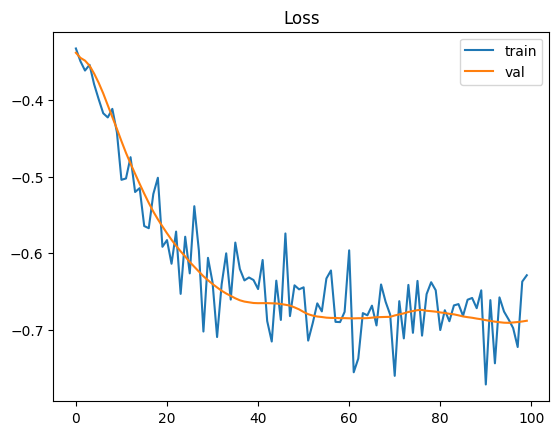

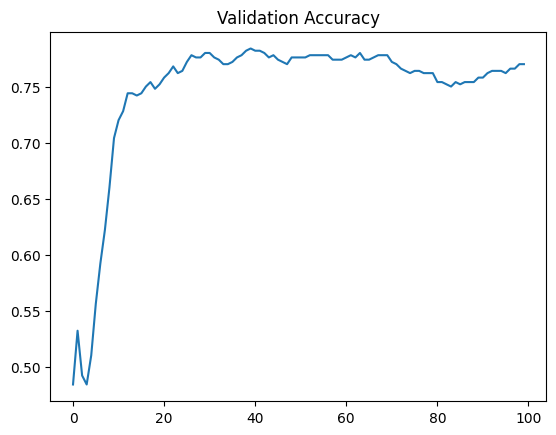

In [8]:
plt.figure()
plt.plot(train_loss_vals)
plt.plot(val_loss_vals)
plt.title("Loss")
plt.legend(['train', 'val'])

plt.figure()
plt.plot(acc_vals)
plt.title('Validation Accuracy')

In [10]:
torch.save(model.state_dict(), './logs/GAT.pt')

Load in pre-trained model that was saved locally.

In [11]:
with open("./logs/GAT.pt", 'rb') as f:
    state_dict = torch.load(f)

In [12]:
model.load_state_dict(state_dict)

<All keys matched successfully>

# Local Explanation

We use the `GNNExplainer` algorithm to explain our model predictions.

In [13]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='probs',
    ),
)

using the `NeighborLoader` object to select a subset of our network dataset. 

In [14]:
from torch_geometric.loader import NeighborLoader

loader = NeighborLoader(
    data=data_train,
    num_neighbors=[10, 10],
    input_nodes=data_train.test_mask,
)

We take an example that consists of at least 10 nodes and one illicit node.

In [15]:
for batch in loader:
    if (batch['x'].shape[0] > 10):
        break

print(batch)
print(batch.y)

Data(x=[48, 500], edge_index=[2, 63], y=[48], train_mask=[48], val_mask=[48], test_mask=[48], n_id=[48], e_id=[63], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[1], batch_size=1)
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 0, 1, 2,
        0, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [16]:
torch.save(batch, 'batch.pt')

In [17]:
batch = torch.load('batch.pt')
batch

Data(x=[48, 500], edge_index=[2, 63], y=[48], train_mask=[48], val_mask=[48], test_mask=[48], n_id=[48], e_id=[63], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[1], batch_size=1)

Generate the explanation:

In [18]:
explanation = explainer(batch.x, batch.edge_index, index=0)

explanation

Explanation(node_mask=[48, 500], edge_mask=[63], prediction=[48, 3], target=[48], index=[1], x=[48, 500], edge_index=[2, 63])

These are the kinds of plots that we get using the default plotting functionality in `torch_geometric`.

In [19]:
plt.figure(figsize=(14,9))
explanation.visualize_graph()

<Figure size 1400x900 with 0 Axes>

Try running the update-desktop-database command. If you
don't have this command you should install the
desktop-file-utils package. This package is available from
http://freedesktop.org/wiki/Software/desktop-file-utils/
No applications found for mimetype: application/pdf
./usr/bin/xdg-open: 882: x-www-browser: not found
/usr/bin/xdg-open: 882: firefox: not found
/usr/bin/xdg-open: 882: iceweasel: not found
/usr/bin/xdg-open: 882: seamonkey: not found
/usr/bin/xdg-open: 882: mozilla: not found
/usr/bin/xdg-open: 882: epiphany: not found
/usr/bin/xdg-open: 882: konqueror: not found
/usr/bin/xdg-open: 882: chromium: not found
/usr/bin/xdg-open: 882: chromium-browser: not found
/usr/bin/xdg-open: 882: google-chrome: not found
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no metho

# Convert the Explanation into a Networkx Graph

In [20]:
from torch_geometric.utils import to_networkx

# store labels into the explanation object - we want to use it in our vis
# store it as 'label' and not 'y' - gravis expects 'y' to store coords
explanation['label'] = batch['y']

# rename 'x' as gravis expects 'x' to store coords
explanation['node_features'] = batch['x']

# convert the explanation into a networkx graph object.
g = to_networkx(
    explanation, 
    
    # these attributes are unique to the graph, so are graph attributes
    graph_attrs=['node_mask', 'edge_mask', 'target', 'label'], 
    
    # the node features are unique for each node, so are node attributes.
    node_attrs=['node_features']
)

Save our explanation and graph locally.

In [21]:
torch.save(explanation, 'explanation.pt')
torch.save(g, 'g.pt')

In [22]:
explanation = torch.load('explanation.pt')
g = torch.load('g.pt')

# Define our Colour Helper class

This will be useful for getting our node and edge colours according to their importance values.

In [31]:
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl


class MplColorHelper:

    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgba(self, val):
        return self.scalarMap.to_rgba(val, bytes=True)

    def get_rgb_str(self, val):
        r, g, b, a = self.get_rgba(val)
        return f"rgb({r},{g},{b})"

# Define our helper functions

The below functions prepares our `networkx` graph object to be plotted in `gravis`.

In [32]:
import numpy as np
import networkx as nx

def set_node_level_importance(g):
    '''Get node level importance'''
    # sum over each feature importance per node to get the overall node importance
    node_level_importance = np.array(g.graph['node_mask']).sum(axis=1)

    # assign the importance value to each node as an attribute
    node_level_importance_dict = { i : node_level_importance[i] for i in g.nodes }
    nx.set_node_attributes(g, node_level_importance_dict, name="importance")

def set_feature_level_importance_per_node(g):
    feature_level_importance = g.graph['node_mask']
    feature_level_importance_per_node = {
        node : feature_level_importance[node] for node in g.nodes
    }
    nx.set_node_attributes(g, feature_level_importance_per_node, name='feature_importance')

def set_edge_level_importance(g):
    '''Get edge level importance'''
    edge_level_importance = g.graph['edge_mask']
    
    # assign the importance value to each edge as an attribute
    edge_level_importance_dict = { edge : edge_level_importance[i] for i, edge in enumerate(g.edges) }
    nx.set_edge_attributes(g, edge_level_importance_dict, name="importance")

def set_node_shapes(g, class_to_label_map:dict):
    target = g.graph['target']
    for i, node in enumerate(g.nodes()):
        g.nodes[node]['shape'] = class_to_label_map[target[i]]

def set_node_colors(g, cmap='winter'):
    '''Set colours based on importance values'''
    # scale our colourmap to be between the min-max importance
    vals = nx.get_node_attributes(g, 'importance').values()
    min_val, max_val = min(vals), max(vals)
    
    # initialise colour helper
    node_color_generator = MplColorHelper(cmap, min_val, max_val)

    # get rgb string for each node
    node_colors = { 
        node : node_color_generator.get_rgb_str(data['importance']) for node, data in g.nodes(data=True) 
    }
    nx.set_node_attributes(g, node_colors, name='color')

def set_edge_colors(g, cmap='winter'):
    '''Set colours based on importance values'''
    # scale our colourmap to be between the min-max importance
    vals = nx.get_edge_attributes(g, 'importance').values()
    min_val, max_val = min(vals), max(vals)

    # initialise colour helper
    edge_color_generator = MplColorHelper(cmap, min_val, max_val)

    # get rgb string for each edge
    edge_colors = {
        (u, v) : edge_color_generator.get_rgb_str(data['importance']) for u, v, data in g.edges(data=True)
    }
    nx.set_edge_attributes(g, edge_colors, name='color')


def rename_node_attribute(g, from_name:str, to_name:str):
    for _, data in g.nodes(data=True):
        try:
            data[to_name] = data.pop(from_name)
        except KeyError: 
            warnings.warn(f"Key {from_name} not found")

def set_node_label(g):
    label = g.graph['label']
    for node, data in g.nodes(data=True):
        data['label'] = label[node]

In [33]:
class ClickComponents():
    HEADER_COMPONENT = "Importance Values:"
    LABEL_COMPONENT = "Label: {}"
    NEWLINE = "\n"

    NODE_HEADER = LABEL_COMPONENT + NEWLINE + HEADER_COMPONENT + NEWLINE
    EDGE_HEADER = HEADER_COMPONENT + NEWLINE

    NODE_IMPORTANCE_ROW = "Node Importance: {}" + NEWLINE
    EDGE_IMPORTANCE_ROW = "Edge Importance: {}" + NEWLINE

    FEATURE_IMPORTANCE_ROW = "{0} : {1}" + NEWLINE


def set_node_click_display(g, feature_names:list[str]):
    for _, data in g.nodes(data=True):
        # initialise click information as empty string. 
        data['click'] = ""

        # add label information
        data['click'] += ClickComponents.NODE_HEADER.format(data['label'])

        # set header + node importance value
        node_attribution = data['importance']
        data['click'] += ClickComponents.NODE_IMPORTANCE_ROW.format(node_attribution)

        # set feature level importance values
        vals = data['feature_importance']
        idx = np.argsort(vals)              # default ascending order
        descending_order_idx = idx[::-1]    # change to descending order
        ordered_vals = np.array(vals)[descending_order_idx]
        ordered_names = np.array(feature_names)[descending_order_idx]
        
        for name, val in zip(ordered_names, ordered_vals):
            data['click'] += ClickComponents.FEATURE_IMPORTANCE_ROW.format(name, val)

def set_edge_click_display(g):
    for _, _, data in g.edges(data=True):
        # set header + edge attribution value
        edge_attribution = data['importance']
        data['click'] = ClickComponents.EDGE_HEADER
        data['click'] += ClickComponents.EDGE_IMPORTANCE_ROW.format(edge_attribution)

        # No feature level importance values for edges. 
        

Pass our `networkx` graph through the helper functions to prep it for `gravis`.

In [34]:
import gravis as gv

class_to_label_map = {
    0 : 'dot',
    1 : 'rectangle',
    2 : 'hexagon',
}

set_node_level_importance(g)
set_node_colors(g)
set_node_shapes(g, class_to_label_map)
set_feature_level_importance_per_node(g)

set_node_label(g)
set_node_click_display(g, [f"Feature {i}" for i in range(500)])

set_edge_level_importance(g)
set_edge_colors(g)
set_edge_click_display(g)

Finally, generate our plot.

In [35]:
gv.d3(
    g, 

    graph_height=700,

    node_size_data_source='importance',
    use_node_size_normalization=True,
    node_size_normalization_min=15,
    node_size_normalization_max=35,

    node_label_data_source='label',

    edge_size_data_source='importance',
    use_edge_size_normalization=True,
    edge_size_normalization_min=1,
    edge_size_normalization_max=5,

    use_collision_force=False,
    collision_force_radius=50,
    collision_force_strength=1,
)